In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
data = pd.read_csv("../daily_data.csv")

In [3]:
data['Dates'] = pd.to_datetime(data['Dates'])
data = data.set_index('Dates')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 971 entries, 2013-12-13 to 2017-10-20
Data columns (total 5 columns):
Soybean     971 non-null float64
Corn        971 non-null float64
CrudeOil    971 non-null float64
DXY         971 non-null float64
S&P500      971 non-null float64
dtypes: float64(5)
memory usage: 45.5 KB


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa9598012b0>,
      dtype=object)

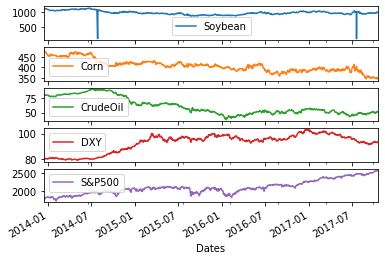

In [5]:
data.plot(subplots=True)

In [6]:
to_keep = data[data['Soybean']>500].index
value = data.loc[to_keep, 'Soybean'].mean()
data['Soybean'].loc[(data['Soybean']<500)] = pd.np.nan
data['Soybean'] = data['Soybean'].interpolate()

In [7]:
#to_keep = data[data['Soybean']>500].index
#value = data.loc[to_keep, 'Soybean'].mean()
#data['Soybean'].loc[(data['Soybean']<500)] = value

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa984401b70>,
      dtype=object)

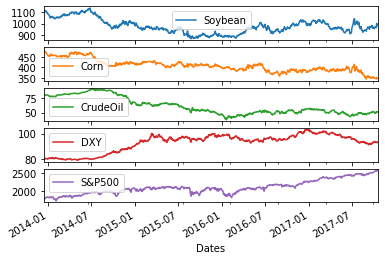

In [8]:
data.plot(subplots=True)

In [9]:
data.head()

,Soybean,Corn,CrudeOil,DXY,S&P500
Dates,,,,,
2013-12-13,1101.75,489.50,80.46,80.209999,1775.319946
2013-12-16,1106.50,479.25,80.78,80.070000,1786.540039
2013-12-17,1109.00,474.75,80.91,80.059998,1781.000000
2013-12-18,1103.75,474.50,80.25,80.110001,1810.650024
2013-12-19,1107.25,472.00,79.90,80.629997,1809.599976


In [10]:
print("Soybean: [", data['Soybean'].min(), ";", data['Soybean'].max(), "]")
print("Corn: [", data['Corn'].min(), ";", data['Corn'].max(), "]")
print("Crude Oil: [", data['CrudeOil'].min(), ";", data['CrudeOil'].max(), "]")
print("DXY: [", data['DXY'].min(), ";", data['DXY'].max(), "]")
print("S&P500: [", data['S&P500'].min(), ";", data['S&P500'].max(), "]")

Soybean: [ 867.75 ; 1135.75 ]
Corn: [ 344.5 ; 489.5 ]
Crude Oil: [ 38.22 ; 90.06 ]
DXY: [ 79.139999 ; 103.290001 ]
S&P500: [ 1741.890015 ; 2575.209961 ]


In [11]:
returns = pd.np.log(data/data.shift(1))
no_assets = len(returns.columns.tolist())

In [12]:
MC_returns = []
MC_vols = []
N = 100000

In [13]:
for i in tqdm(range(N)):
    weights = pd.np.random.rand(no_assets)
    weights /= pd.np.sum(weights)
    MC_returns.append(pd.np.sum(returns.mean()*weights)*252)
    MC_vols.append((pd.np.sqrt(pd.np.dot(weights.T, pd.np.dot(returns.cov()*252, weights)))))

100%|██████████| 100000/100000 [05:33<00:00, 300.25it/s]


In [39]:
MC_sharpe = [x/y for x, y in tqdm(zip(MC_returns, MC_vols))]

100000it [00:00, 1815723.88it/s]


Text(0, 0.5, 'Sharpe Ratio')

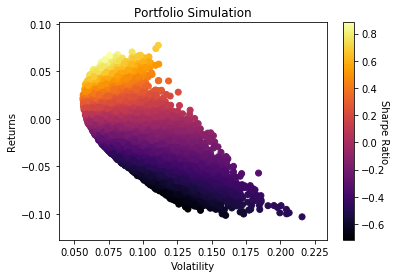

In [15]:
#create scatter plot coloured by Sharpe Ratio
plt.scatter(MC_vols,MC_returns,c=MC_sharpe,cmap='inferno')
plt.title('Portfolio Simulation')
plt.xlabel("Volatility")
plt.ylabel("Returns")
clb = plt.colorbar()
clb.ax.set_ylabel("Sharpe Ratio", rotation = 270)

In [16]:
def portfolio(weights):
    weights = pd.np.array(weights)
    P_ret = pd.np.sum(returns.mean()*weights)*252
    P_vol = pd.np.sqrt(pd.np.dot(weights.T, pd.np.dot(returns.cov()*252, weights)))
    return pd.np.array([P_ret, P_vol, P_ret/P_vol])

In [17]:
def Sharpe(weights):
    return -portfolio(weights)[2]

In [18]:
cons = ({'type':'eq',
        'fun': lambda x: pd.np.sum(x)-1})

In [19]:
bnds = tuple((0,1) for x in range(no_assets))

In [20]:
import scipy.optimize as sco

opt_S = sco.minimize(Sharpe, no_assets*[1.0/no_assets],
                    method = 'SLSQP', bounds = bnds,
                    constraints = cons)

In [21]:
print("Weights: ", opt_S['x'].round(3))
portfolio(opt_S['x'])

Weights:  [0.    0.    0.    0.522 0.478]


array([0.06728292, 0.07346709, 0.91582384])

In [22]:
def Variance(weights):
    return portfolio(weights)[1]**2

In [23]:
cons = ({'type':'eq',
        'fun': lambda x: pd.np.sum(x)-1})

In [24]:
bnds = tuple((0,1) for x in range(no_assets))

In [25]:
opt_V = sco.minimize(Variance, no_assets*[1.0/no_assets],
                    method = 'SLSQP', bounds = bnds,
                    constraints = cons)

In [26]:
print("Weights: ", opt_V['x'].round(3))
portfolio(opt_V['x'])

Weights:  [0.115 0.108 0.028 0.62  0.129]


array([0.02082847, 0.0562941 , 0.3699939 ])

In [27]:
TargetRet = pd.np.linspace(0.0 ,0.25 ,50)

In [28]:
MinVols = []

In [29]:
for tret in tqdm(TargetRet):
    cons=({'type':'eq',
          'fun':lambda x: portfolio(x)[0]-tret},
         {'type':'eq',
        'fun': lambda x: pd.np.sum(x)-1})
    res = sco.minimize(lambda x: portfolio(x)[1], no_assets*[1.0/no_assets],
                    method = 'SLSQP', bounds = bnds,
                    constraints = cons)
    MinVols.append(res['fun'])

100%|██████████| 50/50 [00:33<00:00,  1.50it/s]


In [30]:
normalize = lambda x: (x-x.mean())/x.std()

In [31]:
from sklearn.decomposition import KernelPCA

In [32]:
pca = KernelPCA().fit(data.apply(normalize))

In [33]:
len(pca.lambdas_)

483

In [34]:
fractions = lambda x: x/x.sum()
var_ratio = fractions(pca.lambdas_)[:10]

In [35]:
pca = KernelPCA(n_components=1).fit(data.apply(normalize))

data['PCA_1'] = pca.transform(-data)

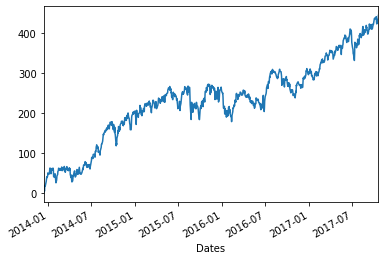

In [36]:
data['PCA_1'].plot()

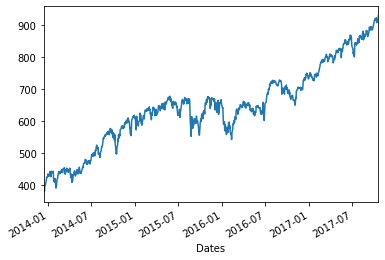

In [37]:
pca = KernelPCA(n_components=5).fit(data.apply(normalize))
pca_components = pca.transform(-data)
weights = fractions(pca.lambdas_)
data['PCA_5'] = pd.np.dot(pca_components, weights)
data['PCA_5'].plot()

In [38]:
weights

array([0.75664456, 0.15050105, 0.04650241, 0.02618015, 0.02017183])

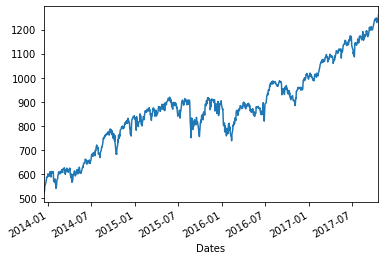

In [40]:
pca = KernelPCA(n_components=3).fit(data.apply(normalize))
pca_components = pca.transform(-data)
weights = fractions(pca.lambdas_)
data['PCA_3'] = pd.np.dot(pca_components, weights)
data['PCA_3'].plot()

In [41]:
weights

array([0.80650992, 0.1517779 , 0.04171218])